In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../')

from galaxybrain import ramsey

# This notebook is to plot figures that summarize all the results (mainly for presentation purposes)
    - probably will retire soon because it doesn't fit well with the other notebooks
## All correlations summary

Three methods: 
1. Average correlation for all (mouse<sub>n</sub>, region<sub>n</sub>)
    - Done
2. f(subset) = correlation plot as in ramsey.py (blue plot) but for all (mouse<sub>n</sub>, region<sub>n</sub>)
    - Problematic because it is distorted by large region sizes normalize for all subset sizes?
2. Heatmap (heat is correlation)
    - .
    
Probably shouldn't have done this with classes as it makes things confusing

## All (mouse, region) results at bottom 
--> plotted on fig_viz.html

In [21]:
class SummaryPlots: 
    def __init__(self):
        self.mice_regions = {'krebs': [[], [('all', 1462), ('CP', 176), ('HPF', 265), ('LS', 122), ('MB', 127), ('TH', 227), ('V1', 334)]],
               'robbins': [[], [('all', 2688), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('RSP', 112), ('SomMoCtx', 220), ('TH', 638), ('V1', 251), ('V2', 124)]],
               'waksman': [[], [('all', 2296), ('CP', 134), ('HPF', 155), ('TH', 1878)]] }
        
        all_regions = []
        for i_m, mouse_key in enumerate(['krebs', 'robbins', 'waksman']):
            for region in self.mice_regions[mouse_key][1]:
                all_regions.append(region[0])
        self.all_regions = np.unique(all_regions)

        #self.corr_df = pd.DataFrame(index = self.all_regions, columns = ['Mouse 1', 'Mouse 2', 'Mouse 3'])
        
        #design settings
        plt.rcParams['mathtext.default'] = 'regular'
        font = {'family' : 'Arial',
               'weight' : 'regular',
               'size'   : 16}
        plt.rc('font', **font)
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
    
    def array_sig(self, data):
        """(Helper function) Compute if 50% of p values are <= 0.05
        This "determines" if a specific mouse region is significantly correlated"""
        bools = data <= 0.05
        return len([1 for i in bools if i == True]) >= 0.5*len(data)
    
    def mouse_region_iterator(self, plot_type, verbose, spec = None, CKEYS = None, marker = None):
        """
        Iterates through mouse-region pairs to extract relevant statistics.  For certain plots does some of the plotting.
        plot_type: either 'heat map', 'all corr', avg corr' or 'avg pca exp'
        CKEYS, marker are specific plotting vars (for 'avg pca exp')
        """
        debug = []
        fractions = np.linspace(.0625,1,16)
        if plot_type == "heat map":
            self.mouse_heat_maps = [pd.DataFrame(index = self.all_regions, columns = fractions), pd.DataFrame(index = self.all_regions, columns = fractions), pd.DataFrame(index = self.all_regions, columns = fractions)]
        elif plot_type == "avg corr":
            self.corr_df = pd.DataFrame(index = self.all_regions, columns = ['Mouse 1', 'Mouse 2', 'Mouse 3'])
            
        for i_m, mouse_key in enumerate(['krebs', 'robbins', 'waksman']):
            if verbose:
                print('=============== \n', 'MOUSE:', mouse_key, '\n=============== ')
            for region in self.mice_regions[mouse_key][1]:
                region_name = region[0]; region_count = region[1]
                if verbose:
                    print(mouse_key, region_name, '(size: ', str(region_count) +')')

                subset_sizes = np.linspace(30,region_count,16, dtype=int)
                
                decomp_arr = []
                for i in range(4):
                    with np.load('../data/experiments/exp5/' + mouse_key + '/' + region_name + '/ramsey_'+str(i+1)+'.npz', allow_pickle=True) as data:
                        eigs = data['eigs']
                        pows = data['pows']
                        space_r2 = data['space_r2']
                        time_r2 = data['time_r2']
                        pca_m = data['pca_m']
                        ft_m = data['ft_m']
                        psn_r = data['pearson_r']
                        spn_r = data['spearman_rho']
                        psn_p = data['pearson_p']
                        spn_p = data['spearman_p']

                    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p, space_r2, time_r2])

                decomp_arr = np.array(decomp_arr)

                mouse_df_key = 'Mouse {}'.format(i_m+1)
                
                
                psn_r, spn_r = decomp_arr[:,2], decomp_arr[:,3]
                psn_p, spn_p = decomp_arr[:,4], decomp_arr[:,5]
                n_trials = psn_r.shape[0]
                
                psn_r = np.array([psn_r[i] for i in range(n_trials)], dtype=float)
                spn_r = np.array([spn_r[i] for i in range(n_trials)], dtype=float)

                psn_p = np.array([psn_p[i] for i in range(n_trials)], dtype=float)
                spn_p = np.array([spn_p[i] for i in range(n_trials)], dtype=float)
    
                if plot_type == "avg corr":
                    #n_trials = psn_r.shape[0]
                    sig_bool = self.array_sig(psn_p.mean(0)) or self.array_sig(spn_p.mean(0))
                    debug.append((mouse_key, region_name, sig_bool))
                    #corr_df[mouse_df_key][region_name] = np.mean([np.nanmean(decomp_arr[:,2].mean(0)), np.nanmean(decomp_arr[:,3].mean(0))]) #avg of avg of the 2 correlations for that region
            
                    self.corr_df[mouse_df_key][region_name] = np.mean([np.nanmean(psn_r.mean(0)), np.nanmean(spn_r[:,3].mean(0))]) #avg of avg of the 2 correlations for that region
                
                elif plot_type == 'all corr':
                    #try looking at spearman as well
                    plt.subplot(1,3,i_m+1)
                    #plt.plot(fractions, psn_r.mean(0), marker[i_m]+'-', ms=10, color=CKEYS[np.where(self.all_regions==region[0])[0][0]], alpha = 0.5)
                    plt.plot(fractions, psn_r.mean(0), color=CKEYS[np.where(self.all_regions==region[0])[0][0]], alpha = 0.5, lw = 3)
                    plt.title('Pearson\'s r as function of subset size (Mouse {})'.format(i_m+1))
                    plt.xlim([0,1])
                    plt.xlabel('Fraction of neurons'); plt.ylabel('r')
                
                elif plot_type == 'heat map':
                    psn_r = np.array([psn_r[i] for i in range(n_trials)], dtype=float)
                    #for heat map
                    for i_f, f in enumerate(fractions):
                        self.mouse_heat_maps[i_m][f][region_name] = psn_r.mean(0)[i_f]

                    
                elif plot_type == 'avg pca exp':
                    spec_index_table = {'eig': 0,'pow': 1}
                    i_feat = spec_index_table[spec]
                    plt.plot(subset_sizes, decomp_arr.mean(0)[i_feat].mean(0), marker[i_m]+'-', ms=10, color=CKEYS[np.where(self.all_regions==region[0])[0][0]])
            #         plt.plot(subset_sizes, decomp_arr.mean(0)[i_feat].mean(0)/decomp_arr.mean(0)[i_feat].mean(0)[0], marker[i_m]+'-', ms=10, color=CKEYS[np.where(all_regions==region[0])[0][0]])
            #         plt.plot(subset_sizes, decomp_arr.mean(0)[3], marker[i_m]+'-', ms=10, color=CKEYS[np.where(all_regions==region[0])[0][0]])
                    plt.xscale('log');#plt.yscale('log')
        
    def avg_corr(self, save = False, verbose = False):
        """Bar plot displaying average correlation"""
        self.mouse_region_iterator(plot_type = 'avg corr', verbose = verbose)
        
        self.corr_df.plot.bar(rot=0, figsize=(10,10), color = ['#FFABAB','#C5A3FF', '#85E3FF'])
        plt.tick_params(axis = "x", which = "both", bottom = False)
        plt.xticks(rotation=-45, horizontalalignment='left', fontsize=16)
        for xc in np.arange(.5,10.5,1): #[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
            plt.axvline(x=xc, color='k', linestyle='-', alpha = 0.5, linewidth=.3)
        #plt.axhline(y=0, color='k', linewidth=.2)
        plt.title('Average Inter-spectral Correlation')
        if save:
            plt.savefig('../../fig/conferences+paper/avg_corr_summary')
        plt.show()
            
    def all_corr(self, save = False, verbose = False):
        """1x3 plot of all correlations"""
        CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
        CKEYS.append('#000000')
        plt.figure(figsize=(20,5))

        self.mouse_region_iterator(plot_type = 'all corr', verbose = verbose, CKEYS = CKEYS)
        for i_r, r in enumerate(self.all_regions):
                plt.plot(1,1/16,color=CKEYS[i_r], label=r)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        if save:
            plt.savefig('../../fig/conferences+paper/avg_corr_summary')
        plt.show()
        
    def corr_heat_map(self, save = False, verbose = False):
        """1x3 heatmap"""
        self.mouse_region_iterator(plot_type = 'heat map', verbose = verbose)
        
        #fig, (ax1, ax2, ax3) = plt.subplots(1,3)
        plt.figure(figsize=(20,5))
        for i_m, mouse_key in enumerate(['krebs', 'robbins', 'waksman']):
            plt.subplot(1,3,i_m+1)
            h_map = self.mouse_heat_maps[i_m]
            cmap = matplotlib.cm.bwr
            cmap.set_bad(color='#ababab')
            im = plt.imshow(h_map.fillna(np.nan), 'bwr', extent = [.0625,1,-1,1], aspect='auto')
            plt.xlabel('Fraction of neurons', fontsize = 20)
            
            plt.yticks(ticks = np.linspace(-1,1,12), verticalalignment='baseline', labels = np.flip(h_map.index), fontsize=16)
            plt.title('Mouse {}'.format(i_m + 1), fontsize = 20)
            plt.colorbar(im,fraction=0.046, pad=0.04)
            
        plt.tight_layout()
        if save:
            plt.savefig('../../fig/conferences+paper/corr_heat_map_summary')
        plt.show()
        
    def avg_exp(self, spec, save = False, verbose = False):
        """Plot f(subset_size) = average spectral exponent
        spec = 'eig' or 'pow' 
        """
        CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
        CKEYS.append('#000000')
        marker='o*^'
        plt.figure(figsize=(12,10))

        self.mouse_region_iterator(plot_type = 'avg pca exp', spec = spec, verbose = verbose, CKEYS = CKEYS, marker = marker)

        for i_r, r in enumerate(self.all_regions):
            plt.plot(100,1,color=CKEYS[i_r], label=r)
        plt.legend()
        plt.show()

        if save:
            plt.savefig('../../fig/conferences+paper/avg_pca_exp_summary')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


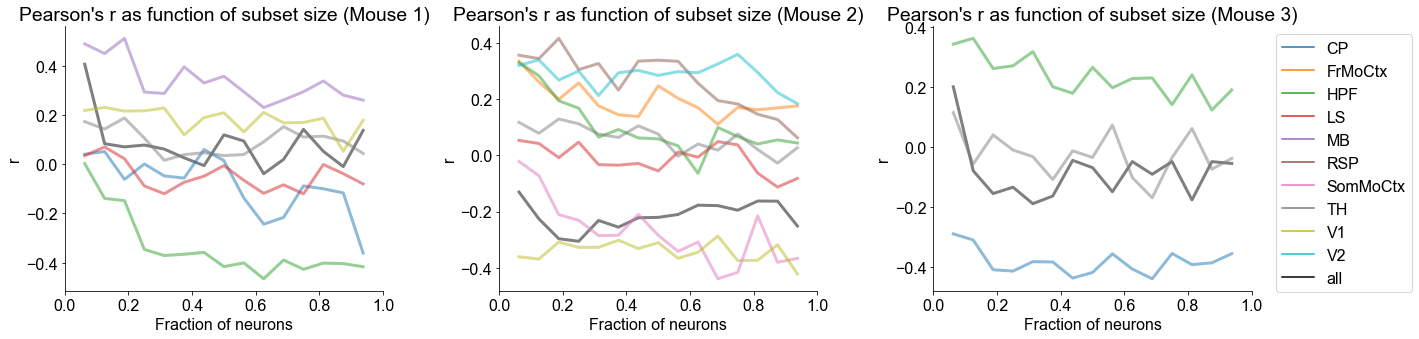

In [22]:
summary = SummaryPlots()
#summary.corr_heat_map(save=True)
summary.all_corr(save=0)

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


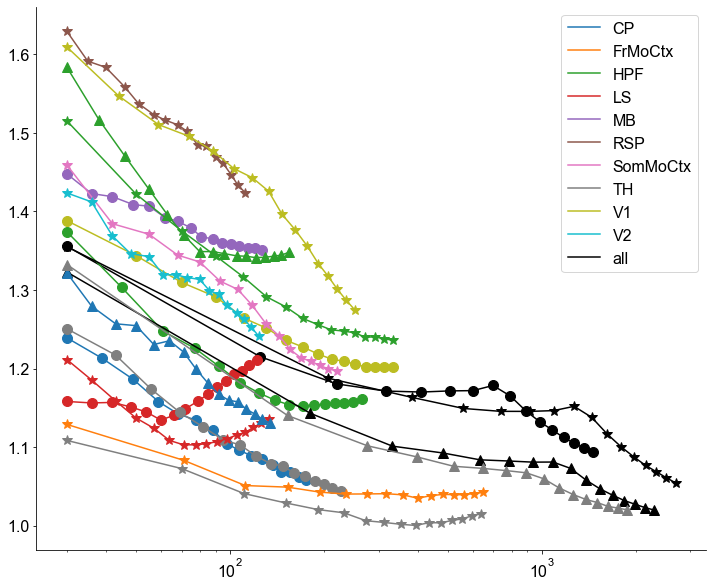

In [23]:
summary.avg_exp(save=0, spec = 'eig')

In [147]:
a = x[0]
plt.imshow(a.fillna(np.nan))

,0.0625,0.1250,0.1875,0.2500,0.3125,0.3750,0.4375,0.5000,0.5625,0.6250,0.6875,0.7500,0.8125,0.8750,0.9375,1.0000
CP,0.040397,0.051391,-0.061494,0.000915,-0.047700,-0.056414,0.059573,0.014580,-0.136958,-0.243537,-0.216096,-0.088078,-0.099770,-0.116683,-0.360445,NaN
FrMoCtx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HPF,0.002583,-0.138829,-0.147963,-0.346297,-0.370981,-0.365657,-0.358212,-0.416064,-0.400778,-0.465361,-0.389088,-0.426882,-0.401645,-0.403643,-0.416530,NaN
LS,0.034870,0.070016,0.022096,-0.088355,-0.119938,-0.073343,-0.048736,-0.005648,-0.065291,-0.118376,-0.083761,-0.120419,-0.001087,-0.038572,-0.080202,NaN
MB,0.488790,0.449388,0.510995,0.292820,0.287455,0.395375,0.329834,0.357271,0.294274,0.229933,0.260893,0.294352,0.337836,0.280520,0.260287,NaN
RSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SomMoCtx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TH,0.172978,0.142675,0.187779,0.105945,0.015802,0.038721,0.046749,0.034860,0.039450,0.090837,0.152564,0.110315,0.113805,0.094172,0.043662,NaN
V1,0.218275,0.230931,0.215693,0.216864,0.228301,0.118876,0.189230,0.208915,0.131084,0.210242,0.168014,0.169454,0.186940,0.052751,0.178569,NaN
V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


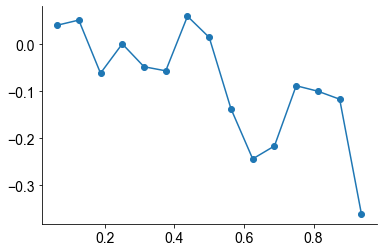

In [286]:
plt.plot(a.T['CP'], 'o-')

Robbins all should be sig, waksman HPF too, all else correct

### Signficance annotations
- https://stackoverflow.com/questions/40489821/how-to-write-text-above-the-bars-on-a-bar-plot-python/40491960
- https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
- https://matplotlib.org/examples/api/barchart_demo.html

Current case: averaging all the correlations for mouse/region (including r and rho)
-  add a star to the bar if a certain amount of p values are <.05?

#### why are there nans in the correlations? (A: because once you are sampling entire population it should be nan)

# Results for each (mouse, region)
spectra, avg exponent, goodness of fit, correlation, p values <br>
Note that some of these are only from the last trial (e.g., \_r2 goodness of fits)

In [ ]:
### SOME REFACTORING DONE (mostly done in explorative_analysis notebook)

#plot + saving figures
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        region_name, region_count, data = region[0], region[1], region[2]
        ramsey.plot_all_measures(*data)
        plt.savefig(f'../fig/vis_time/{mouse_key}_{region_name}_measures')
        
        plt.close('all')
        plt.pause(0.01)